# Medical chat bot/Q&A

### Submitted by: Ani Khvadagiani

-----------------------------

#### Team ABC has decided to work on the following project: 

### Goal and the description:

##### In today's healthcare landscape, navigating vast amounts of medical data from various sources is a common challenge for both patients and medical professionals. This often leads to inefficiencies, delayed decision-making, and increased stress. To address these issues, we propose developing a comprehensive Medical Data Chatbot Ecosystem. This intelligent and user-friendly chatbot will unify and streamline access to medical information, providing users with accurate answers effortlessly, all within a single system.

##### Our primary goal is to launch this innovative solution in poorer countries, with a particular focus on Africa. By creating a multilingual chatbot, we aim to break down language barriers and ensure that users can interact with the system in their preferred language, making medical information accessible to a wider audience.

##### The Medical Data Chatbot Ecosystem will in the future integrate data from multiple sources, such as electronic health records, medical journals, and drug databases. Using advanced natural language processing (NLP) techniques, the chatbot will understand and respond to user queries in everyday language. It will offer personalized responses based on user profiles and specific medical contexts, and support both text and voice interactions to fit to different user preferences.

##### By providing a centralized and intelligent platform, our chatbot will offer significant benefits. Patients will receive quick answers to health-related questions, improving self-care and their understanding of medical conditions. Doctors will gain instant access to comprehensive medical data, aiding in diagnosis and treatment decisions. Researchers will find it easier to retrieve data and trends, facilitating medical advancements.

##### To implement this project, we will follow a structured plan. In the first phase, we will conduct market research and needs assessment, identify key data sources, and define technical specifications. In the second phase, we will develop the chatbot framework, integrate NLP capabilities, and establish secure connections with data sources. The third phase will involve rigorous testing to ensure accuracy, reliability, and security, followed by gathering feedback from a pilot group of users for further refinement.

##### By launching this Medical Data Chatbot Ecosystem, we aim to revolutionize how medical information is accessed and utilized, particularly in resource-limited settings. This project represents a significant step towards improving healthcare outcomes and efficiency, ultimately making a positive impact on communities in Africa and beyond.

___________________

#### Import Libraries:

In [1]:
import requests
import pandas as pd
from tqdm.auto import tqdm
import torch
from sentence_transformers import SentenceTransformer
from transformers import BartTokenizer, BartForConditionalGeneration
import os
from pinecone import Pinecone, ServerlessSpec
import time
from googletrans import Translator
import warnings


#### For the purpose of building a demo application, data on certain diseases has been retrieved from Wikipedia. The list of diseases is provided below. More can be added later if needed.

In [2]:
common_diseases = [
    "Common cold",
    "Influenza",
    "COVID-19",
    "Hypertension",
    "Diabetes mellitus",
    "Asthma",
    "Coronary artery disease",
    "Depression",
    "Anxiety disorder",
    "Stroke",
    "Cancer",
    "Osteoarthritis",
    "Rheumatoid arthritis",
    "Chronic obstructive pulmonary disease",
    "Chronic kidney disease",
    "Hepatitis B",
    "Hepatitis C",
    "Tuberculosis",
    "Malaria",
    "HIV/AIDS",
    "Pneumonia",
    "Urinary tract infection",
    "Gastroesophageal reflux disease",
    "Peptic ulcer disease",
    "Gout",
    "Allergy",
    "Eczema",
    "Psoriasis",
    "Irritable bowel syndrome",
    "Crohn's disease",
    "Ulcerative colitis",
    "Endometriosis",
    "Polycystic ovary syndrome",
    "Benign prostatic hyperplasia",
    "Erectile dysfunction",
    "Fibromyalgia",
    "Chronic fatigue syndrome",
    "Thyroid disorder",
    "Anemia",
    "Osteoporosis",
    "Sickle cell disease",
    "Attention deficit hyperactivity disorder",
    "Autism spectrum disorder",
    "Schizophrenia",
    "Bipolar disorder",
    "Obsessive-compulsive disorder",
    "Alzheimer's disease",
    "Parkinson's disease",
    "Multiple sclerosis",
    "Epilepsy",
    "Migraine",
    "Kidney stones",
    "Pancreatitis",
    "Gastritis",
    "Bronchitis",
    "Cystitis",
    "Prostatitis",
    "Appendicitis",
    "Tonsillitis",
    "Rhinitis",
    "Laryngitis",
    "Thyroiditis",
    "Colitis",
    "Enterocolitis",
    "Ileitis",
    "Pharyngitis",
    "Esophagitis",
    "Pericarditis",
    "Myocarditis",
    "Endocarditis",
    "Pleurisy",
    "Bronchopneumonia",
    "Herpes infection",
    "Influenza",
    "Adenovirus infection",
    "Coronavirus infection",
    "Canine parvovirus",
    "Cytomegalovirus infection",
    "Epstein-Barr virus infection",
    "Human herpesvirus 6",
    "Rubivirus infection",
    "Hepatitis A",
    "Mononucleosis",
    ]


### In this step, we focus on retrieving descriptions of various diseases from Wikipedia using its API. This is crucial for building a comprehensive dataset that can be used for various applications, such as an informational chatbot or a medical information system. The process involves defining the API endpoint, creating a function to fetch the descriptions, and iterating over a list of common diseases to compile their descriptions.

In [3]:
# Wikipedia API endpoint
WIKI_API_URL = "https://en.wikipedia.org/w/api.php"

# Function to fetch disease descriptions from Wikipedia
def get_disease_description(disease):
    try:
        params = {
            'action': 'query',
            'format': 'json',
            'titles': disease,
            'prop': 'extracts',
            'explaintext': True
        }
        response = requests.get(WIKI_API_URL, params=params)
        response.raise_for_status()
        data = response.json()
        page = next(iter(data['query']['pages'].values()))
        return page.get('extract', None)
    except Exception as e:
        print(f"An error occurred for {disease}: {e}")
        return None

# Fetch descriptions for each disease
disease_data = []
for disease in common_diseases:
    print(f"Processed: {disease}")
    description = get_disease_description(disease)
    if description:
        disease_data.append([disease, description])


Processed: Common cold
Processed: Influenza
Processed: COVID-19
Processed: Hypertension
Processed: Diabetes mellitus
Processed: Asthma
Processed: Coronary artery disease
Processed: Depression
Processed: Anxiety disorder
Processed: Stroke
Processed: Cancer
Processed: Osteoarthritis
Processed: Rheumatoid arthritis
Processed: Chronic obstructive pulmonary disease
Processed: Chronic kidney disease
Processed: Hepatitis B
Processed: Hepatitis C
Processed: Tuberculosis
Processed: Malaria
Processed: HIV/AIDS
Processed: Pneumonia
Processed: Urinary tract infection
Processed: Gastroesophageal reflux disease
Processed: Peptic ulcer disease
Processed: Gout
Processed: Allergy
Processed: Eczema
Processed: Psoriasis
Processed: Irritable bowel syndrome
Processed: Crohn's disease
Processed: Ulcerative colitis
Processed: Endometriosis
Processed: Polycystic ovary syndrome
Processed: Benign prostatic hyperplasia
Processed: Erectile dysfunction
Processed: Fibromyalgia
Processed: Chronic fatigue syndrome
Pr

#### After fetching the descriptions for each disease from the list above we form a dataframe:

In [4]:
df = pd.DataFrame(disease_data, columns=["Name", "Description"])

#### Since we do not manually check the volume of generated data, it is important to see how large it actually is. Sometimes, Wikipedia provides immense data on a topic, making it difficult to process. Therefore, we need to observe the fluctuations in the number of characters in each generated textual description of the disease.

(<Axes: xlabel='Name'>,)

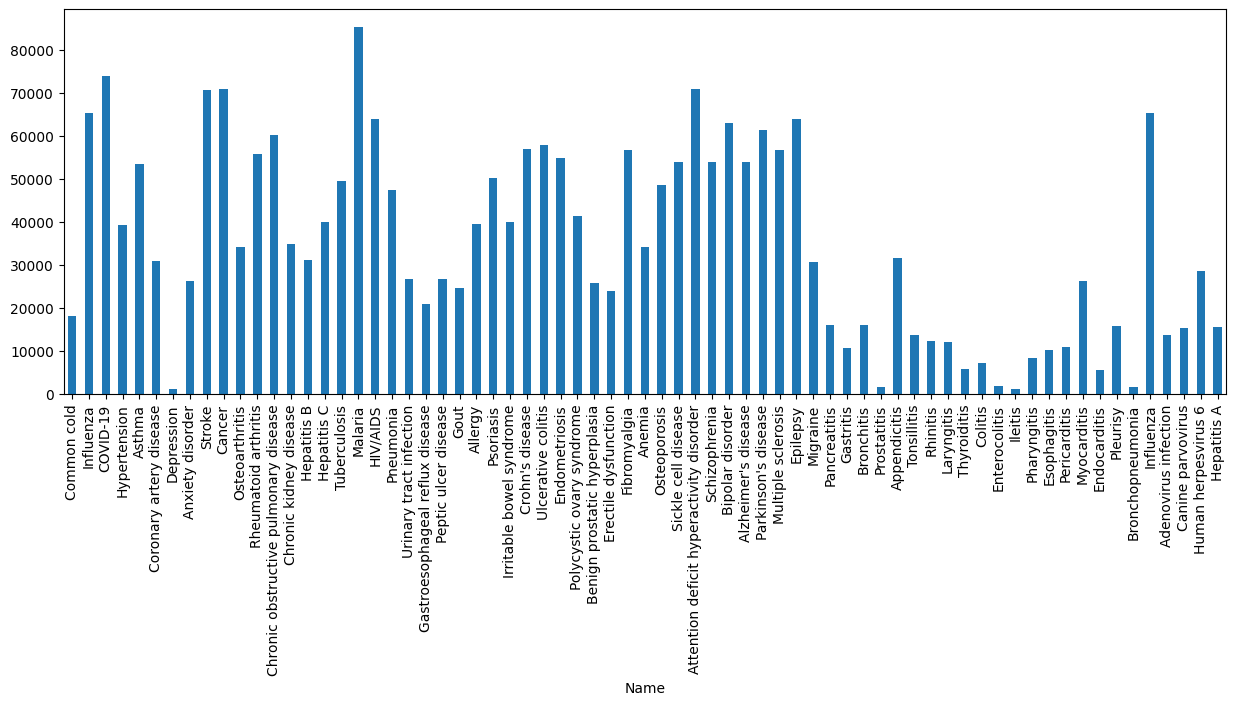

In [5]:
# Function to calculate description length
df['Description_Length'] = df['Description'].apply(len)

description_lengths = df[['Name', 'Description_Length']]

# Visualizing the number of characters in each disease description by a simple chart:
description_lengths.plot(kind='bar', x='Name', y='Description_Length', legend=False, figsize=(15,5)),


#### According to the graph, the length of articles varies from less than 10,000 to more than 80,000 characters. Although it is more convenient to work with the original form, for the sake of this demo version being fast and observable, we will work with relatively shorter data. Therefore, in the script below, we cut the length to 5,000 characters.

In [6]:
# Function to truncate descriptions
def truncate_description(description, word_limit):
    words = description.split()
    return ' '.join(words[:word_limit]) if len(words) > word_limit else description

# Apply truncation
word_limit = 5000
df['Description'] = df['Description'].apply(lambda x: truncate_description(x, word_limit))

#### In this step, we initialize a list docs to store dictionaries containing article titles and truncated passage texts. We use the tqdm library to provide a progress bar during iteration over rows in the DataFrame df. For each row, we extract the disease name and description to the first 5000 characters. 

In [7]:
docs = []
for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    doc = {
        "article_title": row["Name"],
        "passage_text": row["Description"]
    }
    docs.append(doc)

df = pd.DataFrame(docs)
df.head()

Processing:   0%|          | 0/69 [00:00<?, ?it/s]

,article_title,passage_text
0,Common cold,The common cold or the cold is a viral infecti...
1,Influenza,"Influenza, commonly known as ""the flu"" or just..."
2,COVID-19,Coronavirus disease 2019 (COVID-19) is a conta...
3,Hypertension,"Hypertension, also known as high blood pressur..."
4,Asthma,Asthma is a long-term inflammatory disease of ...


 #### The project initializes Pinecone, a service designed for managing vector embeddings efficiently. Using an API key for authentication, Pinecone is configured to operate on AWS in the us-east-1 region. The script creates index with dimensions set at 768 and a cosine similarity metric. The index creation is followed by a wait period to ensure it's ready for use. This setup is significant as it establishes the foundation for storing and querying disease description embeddings swiftly and effectively, essential for the project's question-answering capabilities.

#### **Remark:**
In the context of building a chatbot for medical data retrieval from multiple sources, Pinecone offers several advantages that make it particularly suitable. Most importantly efficient Vector Search: Pinecone specializes in vector similarity search, which is crucial for retrieving relevant medical information based on semantic similarities. This capability allows the chatbot to quickly find and present the most relevant answers from a large dataset, enhancing user experience by providing quick and accurate responses.

In [8]:
api_key = "51a18e49-24b1-4814-a3de-2e6a11cc1e83"
pc = Pinecone(api_key=api_key)
cloud = 'aws'
region = 'us-east-1'
spec = ServerlessSpec(cloud=cloud, region=region)
index_name = "abstractive-question-answering-3"

if index_name not in pc.list_indexes().names():
    pc.create_index(index_name, dimension=768, metric='cosine', spec=spec)
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

index = pc.Index(index_name)

#### Following to that, we initialize a retriever model using the SentenceTransformer library. This model, named "flax-sentence-embeddings/all_datasets_v3_mpnet-base," is designed to generate embeddings (numerical representations) of sentences or passages of text. By specifying device='cuda' if torch.cuda.is_available() else 'cpu', we ensure that the model utilizes GPU acceleration if a compatible GPU is available; otherwise, it defaults to CPU.

In [9]:
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
retriever = SentenceTransformer("flax-sentence-embeddings/all_datasets_v3_mpnet-base", device=device)

warnings.filterwarnings("ignore")

Down below we process the documents prepared in Steps utilizing Pinecone's capabilities for efficient vector storage and retrieval.

We iterate over the DataFrame 'df' in batches (defined by batch_size = 64), encoding each batch's textual passages into embeddings using the retriever model initialized. These embeddings convert the textual data into numerical representations that capture semantic meanings and similarities.

For each batch:
1. We extract the passages from the DataFrame and encode them into embeddings.
2. Metadata about each passage (such as article title and truncated description) is extracted and converted into dictionaries.
3. Unique IDs are assigned to each document for identification and management within Pinecone.
4. The embeddings, metadata, and IDs are wrapped into 'to_upsert' lists, which are then uploaded or updated in the Pinecone index using 'index.upsert(vectors=to_upsert)'.

This step ensures that the chatbot's knowledge base remains current and optimized for fast and accurate retrieval of medical information based on user queries. By leveraging Pinecone's infrastructure and the powerful semantic embeddings from SentenceTransformer, the chatbot can efficiently handle diverse queries and provide relevant responses in real-time.

In [10]:
# Upsert Documents to Pinecone
batch_size = 64
for i in tqdm(range(0, len(df), batch_size)):
    i_end = min(i + batch_size, len(df))
    batch = df.iloc[i:i_end]
    emb = retriever.encode(batch["passage_text"].tolist()).tolist()
    meta = batch.to_dict(orient="records")
    ids = [f"{idx}" for idx in range(i, i_end)]
    to_upsert = list(zip(ids, emb, meta))
    _ = index.upsert(vectors=to_upsert)

  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
# Check index stats
index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 69}},
 'total_vector_count': 69}

- The embeddings are 768-dimensional vectors.

- index_fullness value of 0.0 suggests that the index is not fully utilized yet.

- 69 vectors indexed under this namespace.

- total_vector_count: here, it confirms that there are 69 vectors in total.

#### This step below involves initializing the BART tokenizer and model, which are essential for natural language processing tasks such as question answering and summarization. The BART tokenizer converts text into tokens that the model understands, while the BART model itself generates responses or summaries based on those tokens. This step is crucial as it enables the application to process and generate meaningful responses to user queries, leveraging state-of-the-art language model capabilities for effective communication and information retrieval.

In [12]:
# Load BART Tokenizer and Model
tokenizer = BartTokenizer.from_pretrained('vblagoje/bart_lfqa')
generator = BartForConditionalGeneration.from_pretrained('vblagoje/bart_lfqa').to(device)
warnings.filterwarnings("ignore")

#### functions below collectively facilitate the question answering process using Pinecone, BART models, and the SentenceTransformer retriever:

In [13]:
# Function to query Pinecone
def query_pinecone(query, top_k):
    xq = retriever.encode([query]).tolist()
    xc = index.query(vector=xq, top_k=top_k, include_metadata=True)
    return xc
"""Encodes the query using the retriever model,
   submits it to Pinecone for vector search, retrieves the top-k matching documents, 
   and returns them along with metadata."""

# Function to format query
def format_query(query, context):
    context = [f" {m['metadata']['passage_text']}" for m in context]
    context = " ".join(context)
    query = f"question: {query} context: {context}"
    return query
""" Formats the query and the retrieved context passages into a single query string
    that the BART model can process effectively, ensuring the query context is properly structured."""

# Function to generate answer
def generate_answer(query):
    inputs = tokenizer([query], max_length=1024, return_tensors="pt").to(device)
    ids = generator.generate(inputs["input_ids"], num_beams=2, min_length=20, max_length=38, eos_token_id=tokenizer.eos_token_id)
    answer = tokenizer.batch_decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    return answer

"""Tokenizes the formatted query, feeds it into the BART model to generate a response,
   and decodes the model's output to provide a human-readable answer.
   This function completes the end-to-end process of answering questions based on the input query and relevant context retrieved from Pinecone."""

"Tokenizes the formatted query, feeds it into the BART model to generate a response,\n   and decodes the model's output to provide a human-readable answer.\n   This function completes the end-to-end process of answering questions based on the input query and relevant context retrieved from Pinecone."

___________________________

# Testing the model performance:

#### Test query, the quesion to be asked:

In [14]:
query = "What are the symptoms of Covid-19?"

#### Generating the answer from the model:

In [15]:
result = query_pinecone(query, top_k=1)
formatted_query = format_query(query, result["matches"])

generated_answer = generate_answer(formatted_query)
print("Generated Answer:", generated_answer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Generated Answer: The symptoms of COVID-19 are variable but often include fever, fatigue, cough, breathing difficulties, loss of smell, and loss of taste. Some complications result in death,


#### In order to check how close is the generated answer to the one in the source, we implemented the accuracy test:

In [16]:
# Manually insert the original description
original_description = """The symptoms of COVID-19 are variable but often include fever, fatigue, cough, breathing difficulties, loss of smell, and loss of taste. """

print("Original Description:", original_description)

# Compare the generated answer to the original description
from difflib import SequenceMatcher

def similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

similarity_score = similarity(original_description, generated_answer)
print(f"Similarity Score: {similarity_score:.2f}")

Original Description: The symptoms of COVID-19 are variable but often include fever, fatigue, cough, breathing difficulties, loss of smell, and loss of taste. 
Similarity Score: 0.89


In this particular case the 89% of accuracy is very satisfactory, indicating models successful performance.

#### Limitations:

In [17]:
# Another test query
query = "If I have fewer and caught do I have Covid-19?"
result = query_pinecone(query, top_k=5)
formatted_query = format_query(query, result["matches"])
answer = generate_answer(formatted_query)
print(answer)

Yes, you have Covid-19. It is a virus that is spread by contact with the respiratory mucosa of the respiratory tract. The respiratory mucosa is the mucous


Although the generated answer seems reasonable based on the source, it does not end at a natural sentence boundary, such as at the end of a sentence or after a period. This is because we have to explicitely indicate the size of the answer beforehand. In our model it is 38 characters.

In [18]:
# Another test query
query = "What causes Malaria?"
result = query_pinecone(query, top_k=5)
formatted_query = format_query(query, result["matches"])
answer = generate_answer(formatted_query)
print(answer)

Malaria is caused by a single-celled parasite that lives in the blood of humans. It is spread exclusively through bites of infected female Anopheles mosquitoes. The parasite is


____________________________________________

# Translation: 

### As it was the aim of the project to make it user friendly and diverse, we offer the application in multiple languages:

---

**Please choose your language by its abbreviation. Refer to the list below for the correct abbreviations:**

1. **English** - `en`
2. **Spanish** - `es`
3. **Chinese (Simplified)** - `zh-CN`
4. **Hindi** - `hi`
5. **Arabic** - `ar`
6. **Portuguese** - `pt`
7. **Bengali** - `bn`
8. **Russian** - `ru`
9. **Japanese** - `ja`
10. **Punjabi** - `pa`
11. **German** - `de`
12. **Javanese** - `jv`
13. **Korean** - `ko`
14. **French** - `fr`
15. **Telugu** - `te`
16. **Marathi** - `mr`
17. **Tamil** - `ta`
18. **Turkish** - `tr`
19. **Vietnamese** - `vi`
20. **Italian** - `it`
21. **Swahili** - `sw`
22. **Amharic** - `am`
23. **Yoruba** - `yo`
24. **Zulu** - `zu`
25. **Hausa** - `ha`
26. **Igbo** - `ig`
27. **Afrikaans** - `af`
28. **Shona** - `sn`
29. **Somali** - `so`
30. **Oromo** - `om`
31. **Xhosa** - `xh`
32. **Wolof** - `wo`
33. **Sesotho** - `st`
34. **Kinyarwanda** - `rw`
35. **Twi** - `tw`

---

Feel free to replace or add any other languages and their abbreviations as needed.

#### Use case:

**Afikaans**

In [19]:
Language='af'

## Place your question in the below cell:

In [20]:
text= 'Wat veroorsaak Malaria?'

Since the original dataframe is in English, the question asked is also coverted into Eglish first and then its possible to generate the answer.

In [21]:
translator =Translator()
translation = translator.translate(text,src=Language,dest="en")
print(translation.text)

What causes malaria?


The primary answer is generated in English:

In [22]:
query = text
result = query_pinecone(query, top_k=5)
formatted_query = format_query(query, result["matches"])
answer = generate_answer(formatted_query)
print(answer)

Malaria is caused by a single-celled parasite, Plasmodium falciparum. It is spread by the bite of an infected female Anopheles mosquito


In the last step the the user sees the answer in the language the question was asked:

In [23]:
translation = translator.translate(answer,src="en",dest=Language)
print(translation.text)

Malaria word veroorsaak deur 'n enkel-sel-parasiet, Plasmodium falciparum.Dit word versprei deur die byt van 'n besmette vroulike Anopheles -muskiet


-------------------------------------

### Overall, the current model performs adequately by generating relevant answers, yet there is room for enhancement to produce more sophisticated responses. Future iterations could incorporate additional data sources beyond Wikipedia, such as electronic medical records and medical databases. This expansion would enable users to fully leverage the application for obtaining diagnoses and treatment plans in a single platform. Such advancements would significantly enrich the utility and effectiveness of the tool for medical information retrieval and application.

________________________________

### References:

https://app.pinecone.io/organizations/-O0VXl-_t1-kDERBXpAf/projects/2af1164d-5ab0-46ec-80ef-147c02b8055c/indexes

https://www.youtube.com/watch?v=L8U-pm-vZ4c

https://www.youtube.com/watch?v=8PW1VrsHFjc